# Examine the ACCESS-S2 hindcast file structure

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import calendar
from dask.distributed import Client, LocalCluster
import glob
from matplotlib.dates import date2num, set_epoch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import xarray as xr

from unseen.fileio import open_dataset, open_mfforecast
from unseen.eva import fit_gev, check_gev_fit
from unseen import stability
from unseen import independence

In [8]:
home = Path("/g/data/xv83/as3189")

In [9]:
ds = xr.open_dataset("/g/data/oi10/replicas/CMIP6/DCPP/BCC/BCC-CSM2-MR/dcppA-hindcast/s1961-r1i1p1f1/day/pr/gn/v20191126/pr_day_BCC-CSM2-MR_dcppA-hindcast_s1961-r1i1p1f1_gn_19610101-19701231.nc")
ds

<xarray.Dataset>
Dimensions:    (time: 3650, bnds: 2, lat: 160, lon: 320)
Coordinates:
  * time       (time) object 1961-01-01 12:00:00 ... 1970-12-31 12:00:00
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                The model 10-year-long hindcast integration start...
    ...                     ...
    title:                  BCC-CSM2-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/02d594e1-ac7b-4fa6-8e37-b73133736201
    variable_id:            pr
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by BCC is licensed unde...
    cmor_version:           3.3.2

In [10]:
variable = "tasmax"
file_dir = "/g/data/ux62/access-s2/hindcast/raw_model/atmos/{}/daily".format(variable)

n_time_files = 179
n_ensemble_files = 9
n_files = n_time_files * n_ensemble_files
# Create file list for all files.
file_list = str(home / "data/access-s2_hindcast_{}_files.txt".format(variable))

try:
    os.remove(file_list)
except OSError:
    pass

for year in np.arange(1981, 2018 + 1):
    i = 1 if calendar.isleap(year) else 0
    n_files = ((179 + i) * 3) + (72 * 6)
    # for ensemble in range(1, 10):
    infiles = glob.glob(f"{file_dir}/e0*/da_{variable}_{year}*.nc")
    infiles.sort()
    assert len(infiles) == n_files, f"year {year} {variable} does not have {n_files} files"
    with open(file_list, "a") as outfile:
        for item in infiles:
            outfile.write(f"{item}\n")

In [11]:
# Create file list for all files.
file_list = str(home / "data/access-s2_hindcast_{}_files.txt".format(variable))

try:
    os.remove(file_list)
except OSError:
    pass

for year in np.arange(1981, 2018 + 1):
    i = 1 if calendar.isleap(year) else 0
    n_files = ((179 + i) * 3) + (72 * 6)
    # for ensemble in range(1, 10):
    infiles = glob.glob(f"{file_dir}/e0*/da_{variable}_{year}*.nc")
    infiles.sort()
    assert len(infiles) == n_files, f"year {year} {variable} does not have {n_files} files"
    with open(file_list, "a") as outfile:
        for item in infiles:
            outfile.write(f"{item}\n")

In [12]:
# Create file list for ensemble members 4-9
file_list_alt = str(home / "data/access-s2_hindcast_{}_files_subset.txt".format(variable))
try:
    os.remove(file_list)
except OSError:
    pass

for year in np.arange(1981, 1984 + 1):
    i = 1 if calendar.isleap(year) else 0
    n_files = (72 * 6)
    #for ensemble in range(1, 10):
    infiles = glob.glob(f"{file_dir}/e0*/da_{variable}_{year}0101*.nc")
    infiles.sort()
    with open(file_list, "a") as outfile:
        for item in infiles:
            outfile.write(f"{item}\n")

with open(file_list) as f:
    input_files = f.read().splitlines()
input_files

['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19810101_e01.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19810101_e02.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19810101_e03.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19810101_e04.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19810101_e05.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19810101_e06.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19810101_e07.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19810101_e08.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19810101_e09.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19820101_e01.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/

In [13]:
# Print number of files of each ensemble member for each year
for ensemble in range(1, 10):
    nfiles = []
    for year in np.arange(1981, 2018 + 1):
        infiles = glob.glob(f"{file_dir}/e0{ensemble}/da_{variable}_{year}*.nc")
        infiles.sort()
        nfiles.append(len(infiles))
    print('ensemble {:02d}: n_files/year={}'.format(ensemble, nfiles))

ensemble 01: n_files/year=[179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179]
ensemble 02: n_files/year=[179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179]
ensemble 03: n_files/year=[179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179, 179, 180, 179, 179]
ensemble 04: n_files/year=[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]
ensemble 05: n_files/year=[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72,

In [14]:
ds = xr.open_mfdataset("/g/data/ux62/access-s2/hindcast/calibrated/atmos/tasmax/daily/e01/daq5_tasmax_19810101_e01.nc")

In [15]:
# Print unique file lengths of each ensemble.
files = []
for ensemble in range(1, 10):
    files_ensemble = []
    nfiles = []
    for year in np.arange(1981, 2018 + 1):
        infiles = glob.glob(f"{file_dir}/e0{ensemble}/da_tasmax_{year}*.nc")
        infiles.sort()
        files_ensemble.append(infiles)
        nfiles.append(len(infiles))
    print('ensemble {:02d}: n_files={}'.format(ensemble, np.unique(nfiles)))
    files.append(files_ensemble)

ensemble 01: n_files=[179 180]
ensemble 02: n_files=[179 180]
ensemble 03: n_files=[179 180]
ensemble 04: n_files=[72]
ensemble 05: n_files=[72]
ensemble 06: n_files=[72]
ensemble 07: n_files=[72]
ensemble 08: n_files=[72]
ensemble 09: n_files=[72]


In [16]:
# Print file length per month per ensemble.
for ensemble in range(1, 10):
    nfiles = []
    for month in np.arange(1, 13):
        
        for year in np.arange(1981, 2018 + 1):
            infiles = glob.glob("{}/e0{}/da_tasmax_{}{:02d}*.nc".format(file_dir, ensemble, year, month))
            nfiles.append(len(infiles))
    print('ensemble {:02d}: {} n_files/month='.format(ensemble, year), np.unique(nfiles))
        # # Print file length per year per ensemble.
        # infiles = glob.glob(f"{file_dir}/e0{ensemble}/da_tasmax_{year}*.nc")
        # nfiles.append(len(infiles))
        # print('ensemble {:02d}: {} n_files={}'.format(ensemble, year, np.unique(nfiles)))

ensemble 01: 2018 n_files/month= [14 15]
ensemble 02: 2018 n_files/month= [14 15]
ensemble 03: 2018 n_files/month= [14 15]
ensemble 04: 2018 n_files/month= [6]
ensemble 05: 2018 n_files/month= [6]
ensemble 06: 2018 n_files/month= [6]
ensemble 07: 2018 n_files/month= [6]
ensemble 08: 2018 n_files/month= [6]
ensemble 09: 2018 n_files/month= [6]


In [17]:
for year in [1981]:
    for ensemble in [0]:
        infiles = glob.glob(f"{file_dir}/e0{ensemble}/da_tasmax_{year}*.nc")
        infiles.sort() 
        print('ensemble {:02d}: n_files={}'.format(ensemble, len(infiles)))
        #assert len(infiles) == n_files, f"year {year} pr does not have {n_files} files"
        with open(file_list, "a") as outfile:
            for item in infiles:
                outfile.write(f"{item}\n")


ensemble 00: n_files=0


In [18]:
ds = xr.open_mfdataset("/g/data/ux62/access-s2/hindcast/calibrated/atmos/tasmax/daily/e01/daq5_tasmax_19810101_e01.nc")
ds.time

<xarray.DataArray 'time' (time: 279)>
array(['1981-01-01T12:00:00.000000000', '1981-01-02T12:00:00.000000000',
       '1981-01-03T12:00:00.000000000', ..., '1981-10-04T12:00:00.000000000',
       '1981-10-05T12:00:00.000000000', '1981-10-06T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 1981-10-06T12:00:00
Attributes:
    axis:     T

In [5]:
#files = glob.glob("/g/data/ux62/access-s2/hindcast/calibrated/atmos/tasmax/daily/*")
#files.sort()
file_list = str(home / "data/access-s2_hindcast_{}_files_subset.txt".format(variable))

ds = open_mfforecast(file_list, 
                  #file_format="scipy",
                  n_time_files=1, 
                  n_ensemble_files=9,
                  variables=["tasmax"], 
                  point_selection=[-42, 145],
                  #time_freq="A-DEC",
                  #time_agg="max", 
                  input_freq="D", 
                  reset_times=True, 
                  #complete_time_agg_periods=True,
                     verbose=True)
ds

INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19810101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19810101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19810101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19810101_e04.nc']...
INFO:root:Ensemble member shape: (42,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19810101_e05.nc']...
INFO:root:Ensemble member shape: (42,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19810101_e06.nc']...
INFO:root:Ensemb

9
9


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19830101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19830101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19830101_e04.nc']...
INFO:root:Ensemble member shape: (42,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19830101_e05.nc']...
INFO:root:Ensemble member shape: (42,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19830101_e06.nc']...
INFO:root:Ensemble member shape: (42,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasma

9
9


<xarray.Dataset>
Dimensions:    (init_date: 4, ensemble: 9, lead_time: 279)
Coordinates:
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 272 273 274 275 276 277 278
  * init_date  (init_date) object 1981-01-01 00:00:00 ... 1984-01-01 00:00:00
    time       (lead_time, init_date) object 1981-01-01 12:00:00 ... 1984-10-...
Data variables:
    tasmax     (init_date, ensemble, lead_time) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes: (12/25)
    model_id:                ACCESS-S2
    distribution_statement:  The data are subject to the distribution terms o...
    creator_name:            Bureau of Meteorology
    copyright:               (C) Copyright Commonwealth of Australia (2017), ...
    acknowledgement:         Australian Bureau of Meteorology, Commonwealth o...
    title:                   ACCESS-S2
    ...                      ...
    input_file_format:       UM ancillary
    input_uri:               file:///g/sc/home_trial/coupled_trial/cylc-run/s...
    input_word_length:       8
    history:                 Wed Jul 15 12:48:18 2020: ncks -O -v tasmax pc19...
    input_byte_ordering:     big_endian
    NCO:                     "4.5.3"

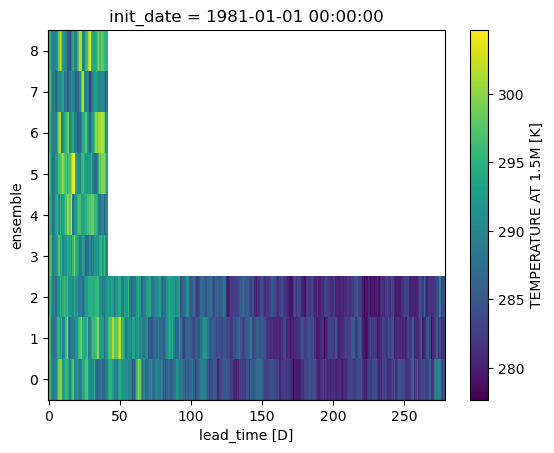

In [10]:
ds.isel(init_date=0).tasmax.plot()
plt.show()

In [20]:
file_list = str(home / "data/access-s2_hindcast_{}_files.txt".format(variable))
with open(file_list) as f:
    input_files = f.read().splitlines()
input_files

['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19810101_e01.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19810101_e02.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19810101_e03.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19810101_e04.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19810101_e05.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19810101_e06.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19810101_e07.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19810101_e08.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19810101_e09.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19820101_e01.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/

# UNSEEN test

In [37]:
var = 'tasmax'
index = 'tx1day_jan'
model = 'ACCESS-S2'
name = "cairns"
coords = [-16.9, 145.8]

In [ ]:
ds = xr.open_dataset('/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19810101_e01.nc')
ds.time

In [38]:
%%time

# Create file list for all files.
file_dir = "/g/data/ux62/access-s2/hindcast/raw_model/atmos/{}/daily".format(var)
file_list = str(home / "data/access-s2_hindcast_{}_files.txt".format(var))

try:
    os.remove(file_list)
except OSError:
    pass
    
# files = []
# for year in np.arange(1981, 2018 + 1):
#     for month in rnge(1, 13):
#         for day in range(1, 31):
#             infiles = glob.glob("{}/e0*/da_{}_{}{:02d}{:02d}*.nc".format(file_dir, var, year, month, day))
#             infiles.sort()
#             with open(file_list, "a") as outfile:
#                 for item in infiles:
#                     files.append(item)
#                     outfile.write(f"{item}\n")

files = []
for year in np.arange(1981, 2018 + 1):
    for month in [1]:
        for day in [1, 16]:  # Note that all ensembles memmbers are init on these days.
            infiles = glob.glob("{}/e0*/da_{}_{}{:02d}{:02d}*.nc".format(file_dir, var, year, month, day))
            infiles.sort()
            assert len(infiles) == 9, f"year {year} {var} does not have 10 files"
            with open(file_list, "a") as outfile:
                for item in infiles:
                    files.append(item)
                    outfile.write(f"{item}\n")
files[:30]

CPU times: user 1.82 s, sys: 506 ms, total: 2.32 s
Wall time: 2.94 s


['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19810101_e01.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19810101_e02.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19810101_e03.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19810101_e04.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19810101_e05.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19810101_e06.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19810101_e07.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19810101_e08.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19810101_e09.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19810116_e01.nc',
 '/g/data/ux62/access-s2/hindcast/raw_model/atmos/

In [30]:
def _chunks(lst, n):
    """Split a list into n sub-lists"""

    new_lst = [lst[i : i + n] for i in range(0, len(lst), n)]

    return new_lst


def _process_mfilelist(file_list, n_time_files, n_ensemble_files):
    """Read and chunk an input file list"""

    if isinstance(file_list, str) or (len(file_list) == 1):
        if len(file_list) == 1:
            file_list = file_list[0]
        with open(file_list) as f:
            input_files = f.read().splitlines()
    else:
        input_files = file_list
    input_files_chunked = _chunks(_chunks(input_files, n_time_files), n_ensemble_files)

    return input_files_chunked

_process_mfilelist(files, n_time_files=1, n_ensemble_files=9)[10]

[['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19860101_e01.nc'],
 ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19860101_e02.nc'],
 ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19860101_e03.nc'],
 ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19860101_e04.nc'],
 ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19860101_e05.nc'],
 ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19860101_e06.nc'],
 ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19860101_e07.nc'],
 ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19860101_e08.nc'],
 ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19860101_e09.nc']]

In [32]:
%%time
def access_s2_preprocess(ds):
    """Preprocess each file before merging."""
    # Pad time dim of 42-day hindcast runs to match 279-day integration runs
    print(ds.time.size)
    if ds.time.size == 42:
        attrs = ds.time.attrs
        ds = ds.pad(time=[0, 279 - 42], constant_values=np.nan)
        ds['time'] = xr.cftime_range(ds.time[0].item(), freq='D', periods=279)
        ds['time'].attrs = attrs

    # ds = ds.isel(time=slice(0, 42)) # tmp bug fix
    # # Select grid point
    # ds = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
    # # Monthly maximum
    # ds = ds.groupby("time.year").max().rename({"year": "time"})
    return ds

ds = open_mfforecast(
    files,
    n_time_files=1,
    n_ensemble_files=9,
    variables=[var],
    point_selection=coords,
    input_freq="D",
    # time_freq="A-DEC",
    # time_agg="max",
    # reset_times=True,
    # complete_time_agg_periods=True,
    preprocess=access_s2_preprocess,
    verbose=False,
)
ds

INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19810101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19810101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19810101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19810101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19810101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19810101_e06.nc']...
INFO:root:Ense

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19810101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19810101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19810116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19810116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19810116_e03.nc']...


42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19810116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19810116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19810116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19810116_e07.nc']...


279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19810116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19810116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19820101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19820101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19820101_e03.nc']...


42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19820101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19820101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19820101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19820101_e07.nc']...


279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19820101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19820101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19820116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19820116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19820116_e03.nc']...


42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19820116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19820116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19820116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19820116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19820116_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19820116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19830101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19830101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19830101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19830101_e04.nc']...


42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19830101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19830101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19830101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19830101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19830101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19830116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19830116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19830116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19830116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19830116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19830116_e06.nc']...


279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19830116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19830116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19830116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19840101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19840101_e02.nc']...
INFO:root:Ensemble member shape: (279,)


42
42
42
279
279


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19840101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19840101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19840101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19840101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19840101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19840101_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19840101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19840116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19840116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19840116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19840116_e04.nc']...


42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19840116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19840116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19840116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19840116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19840116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19850101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19850101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19850101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19850101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19850101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19850101_e06.nc']...


279
279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19850101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19850101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19850101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19850116_e01.nc']...


42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19850116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19850116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19850116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19850116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19850116_e06.nc']...


279
279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19850116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19850116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19850116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19860101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19860101_e02.nc']...


42
42
42
42
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19860101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19860101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19860101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19860101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19860101_e07.nc']...


279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19860101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19860101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19860116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19860116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19860116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19860116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19860116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19860116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19860116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19860116_e09.nc']...


42
42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19870101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19870101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19870101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19870101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19870101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19870101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19870101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19870116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19870116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19870116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19870116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19870116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19870116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19870116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19870116_e09.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19880101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19880101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19880101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19880101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19880101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19880101_e06.nc']...


279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19880101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19880101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19880101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19880116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19880116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19880116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19880116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19880116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19880116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19880116_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19880116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19890101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19890101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19890101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19890101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19890101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19890101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19890101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19890101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19890116_e01.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19890116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19890116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19890116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19890116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19890116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_ta

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19890116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19890116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19900101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19900101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19900101_e03.nc']...


42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19900101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19900101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19900101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19900101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19900101_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19900101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19900116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19900116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19900116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19900116_e04.nc']...


42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19900116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19900116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19900116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19900116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19900116_e09.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19910101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19910101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19910101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19910101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19910101_e05.nc']...


42
279
279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19910101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19910101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19910101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19910101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19910116_e01.nc']...


42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19910116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19910116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19910116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19910116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19910116_e06.nc']...


279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19910116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19910116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19910116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19920101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19920101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19920101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19920101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19920101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19920101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19920101_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19920101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19920116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19920116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19920116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19920116_e04.nc']...


42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19920116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19920116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19920116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19920116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19920116_e09.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19930101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19930101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19930101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19930101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19930101_e05.nc']...


42
279
279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19930101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19930101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19930101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19930101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19930116_e01.nc']...


42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19930116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19930116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19930116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19930116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19930116_e06.nc']...


279
279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19930116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19930116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19930116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19940101_e01.nc']...


42
42
42
42
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19940101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19940101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19940101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19940101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19940101_e06.nc']...


279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19940101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19940101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19940101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19940116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19940116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19940116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19940116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19940116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19940116_e06.nc']...


279
279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19940116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19940116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19940116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19950101_e01.nc']...


42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19950101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19950101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19950101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19950101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19950101_e06.nc']...


279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19950101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19950101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19950101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19950116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19950116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19950116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19950116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19950116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19950116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19950116_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19950116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19960101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19960101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19960101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19960101_e04.nc']...


42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19960101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19960101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19960101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19960101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19960101_e09.nc']...
INFO:root:Ensemble member shape: (279,)


42
42
42
42
42


INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19960116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19960116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19960116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19960116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19960116_e05.nc']...


279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19960116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19960116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19960116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19960116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19970101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19970101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19970101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19970101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19970101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19970101_e06.nc']...


279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19970101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19970101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19970101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19970116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19970116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19970116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19970116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19970116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19970116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19970116_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19970116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19980101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19980101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19980101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19980101_e04.nc']...
INFO:root:Ensemble member shape: (279,)


42
42
279
279
279
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19980101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19980101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19980101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19980101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19980101_e09.nc']...
INFO:root:Ensemble member shape: (279,)


42
42
42
42
42


INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19980116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19980116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19980116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19980116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19980116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19980116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19980116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19980116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19990101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19990101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_19990101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19990101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19990101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19990101_e07.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19990101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19990101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_19990116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_19990116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_19990116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_19990116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_19990116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_19990116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_19990116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_19990116_e09.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20000101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20000101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20000101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20000101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20000101_e05.nc']...
INFO:root:Ensemble member shape: (279,)


42
279
279
279
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20000101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20000101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20000101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20000101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20000116_e01.nc']...


42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20000116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20000116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20000116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20000116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20000116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_ta

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20000116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20000116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20010101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20010101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20010101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20010101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20010101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20010101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20010101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20010101_e09.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20010116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20010116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20010116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20010116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20010116_e05.nc']...


42
279
279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20010116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20010116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20010116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20010116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20020101_e01.nc']...


42
42
42
42
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20020101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20020101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20020101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20020101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20020101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_ta

279
279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20020101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20020101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20020116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20020116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20020116_e03.nc']...


42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20020116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20020116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20020116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20020116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20020116_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20020116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20030101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20030101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20030101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20030101_e04.nc']...


42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20030101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20030101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20030101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20030101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20030101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20030116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20030116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20030116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20030116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20030116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20030116_e06.nc']...
INFO:root:Ense

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20030116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20030116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20040101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20040101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20040101_e03.nc']...


42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20040101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20040101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20040101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20040101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20040101_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20040101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20040116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20040116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20040116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20040116_e04.nc']...


42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20040116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20040116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20040116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20040116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20040116_e09.nc']...
INFO:root:Ensemble member shape: (279,)


42
42
42
42
42


INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20050101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20050101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20050101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20050101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20050101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20050101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20050101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20050116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20050116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20050116_e03.nc']...


42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20050116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20050116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20050116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20050116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20050116_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20050116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20060101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20060101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20060101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20060101_e04.nc']...


42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20060101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20060101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20060101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20060101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20060101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20060116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20060116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20060116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20060116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20060116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20060116_e06.nc']...
INFO:root:Ense

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20060116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20060116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20070101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20070101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20070101_e03.nc']...


42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20070101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20070101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20070101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20070101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20070101_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20070101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20070116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20070116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20070116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20070116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20070116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20070116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20070116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20070116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20080101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20080101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20080101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20080101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20080101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20080101_e06.nc']...


279
279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20080101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20080101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20080101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20080116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20080116_e02.nc']...


42
42
42
42
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20080116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20080116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20080116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20080116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20080116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_ta

279
279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20080116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20090101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20090101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20090101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20090101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20090101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20090101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20090101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20090101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20090116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20090116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20090116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20090116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20090116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20090116_e06.nc']...
INFO:root:Ense

279
279
279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20090116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20090116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20100101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20100101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20100101_e03.nc']...


42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20100101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20100101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20100101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20100101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20100101_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20100101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20100116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20100116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20100116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20100116_e04.nc']...


42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20100116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20100116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20100116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20100116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20100116_e09.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20110101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20110101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20110101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20110101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20110101_e05.nc']...


42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20110101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20110101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20110101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20110101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20110116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20110116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20110116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20110116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20110116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20110116_e06.nc']...


279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20110116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20110116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20110116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20120101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20120101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20120101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20120101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20120101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20120101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20120101_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20120101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20120116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20120116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20120116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20120116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20120116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20120116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20120116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20120116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20130101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20130101_e02.nc']...


279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20130101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20130101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20130101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20130101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20130101_e07.nc']...


279
279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20130101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20130101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20130116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20130116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20130116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20130116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20130116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20130116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20130116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20130116_e09.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20140101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20140101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20140101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20140101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20140101_e05.nc']...


42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20140101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20140101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20140101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20140101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20140116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20140116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20140116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20140116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20140116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20140116_e06.nc']...
INFO:root:Ense

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20140116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20140116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20150101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20150101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20150101_e03.nc']...


42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20150101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20150101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20150101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20150101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20150101_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20150101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20150116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20150116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20150116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20150116_e04.nc']...


42
42
279
279
279
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20150116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20150116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20150116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20150116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20150116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
42
42
42
42


INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20160101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20160101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20160101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20160101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20160101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20160101_e06.nc']...
INFO:root:Ense

279
279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20160101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20160101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20160116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20160116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20160116_e03.nc']...


42
42
42
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20160116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20160116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20160116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20160116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20160116_e08.nc']...


279
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20160116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20170101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20170101_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20170101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20170101_e04.nc']...


42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20170101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20170101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20170101_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20170101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20170101_e09.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20170116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20170116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20170116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20170116_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20170116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
279
279
279
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20170116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20170116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20170116_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20180101_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20180101_e02.nc']...


42
42
42
42
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20180101_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e04/da_tasmax_20180101_e04.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20180101_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20180101_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20180101_e07.nc']...


279
279
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20180101_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20180101_e09.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e01/da_tasmax_20180116_e01.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e02/da_tasmax_20180116_e02.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e03/da_tasmax_20180116_e03.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw

42
42
42
279
279
279


INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e05/da_tasmax_20180116_e05.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e06/da_tasmax_20180116_e06.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e07/da_tasmax_20180116_e07.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e08/da_tasmax_20180116_e08.nc']...
INFO:root:Ensemble member shape: (279,)
INFO:root:Processing file group: ['/g/data/ux62/access-s2/hindcast/raw_model/atmos/tasmax/daily/e09/da_tasmax_20180116_e09.nc']...


42
42
42
42
42


INFO:root:Ensemble member shape: (279,)
INFO:root:Ensemble shape: (9, 279)


42
CPU times: user 16.6 s, sys: 8.7 s, total: 25.3 s
Wall time: 33.1 s


<xarray.Dataset>
Dimensions:    (init_date: 76, ensemble: 9, lead_time: 279)
Coordinates:
    lat        float32 -16.94
    lon        float32 145.4
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 272 273 274 275 276 277 278
  * init_date  (init_date) object 1981-01-01 00:00:00 ... 2018-01-16 00:00:00
    time       (lead_time, init_date) object 1981-01-01 12:00:00 ... 2018-10-...
Data variables:
    tasmax     (init_date, ensemble, lead_time) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes: (12/25)
    model_id:                ACCESS-S2
    distribution_statement:  The data are subject to the distribution terms o...
    creator_name:            Bureau of Meteorology
    copyright:               (C) Copyright Commonwealth of Australia (2017), ...
    acknowledgement:         Australian Bureau of Meteorology, Commonwealth o...
    title:                   ACCESS-S2
    ...                      ...
    input_file_format:       UM ancillary
    input_uri:               file:///g/sc/home_trial/coupled_trial/cylc-run/s...
    input_word_length:       8
    history:                 Wed Jul 15 12:48:18 2020: ncks -O -v tasmax pc19...
    input_byte_ordering:     big_endian
    NCO:                     "4.5.3"

In [1]:
ds

NameError: name 'ds' is not defined

In [ ]:
# Save dataset
outfile = f"{var}_dcppA-hindcast_s1960-2018_jan.zarr.zip"
to_zarr(ds, outfile)
# ds = xr.open_dataset(outfile, engine='zarr')
# ds

In [35]:
ds = ds[var]

/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/xskillscore/core/np_deterministic.

CPU times: user 1h 2min 28s, sys: 1h 9min 40s, total: 2h 12min 8s
Wall time: 2h 42min 59s


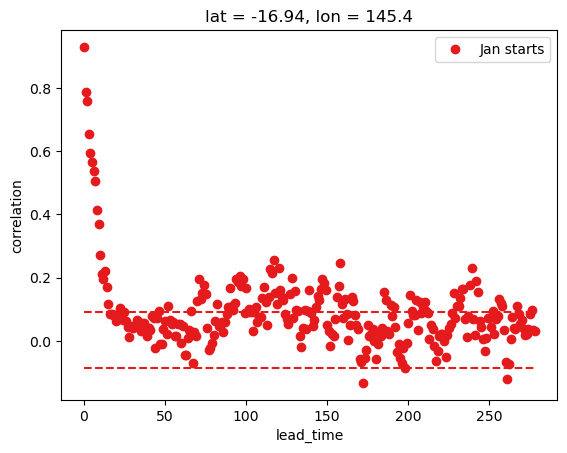

In [36]:
%%time

mean_correlations, null_correlation_bounds = independence.run_tests(ds)
independence.create_plot(
    mean_correlations,
    null_correlation_bounds,
    str(home / f"{index}_independence_{model}.png"),
)

ValueError: dimension sample on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(sample=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

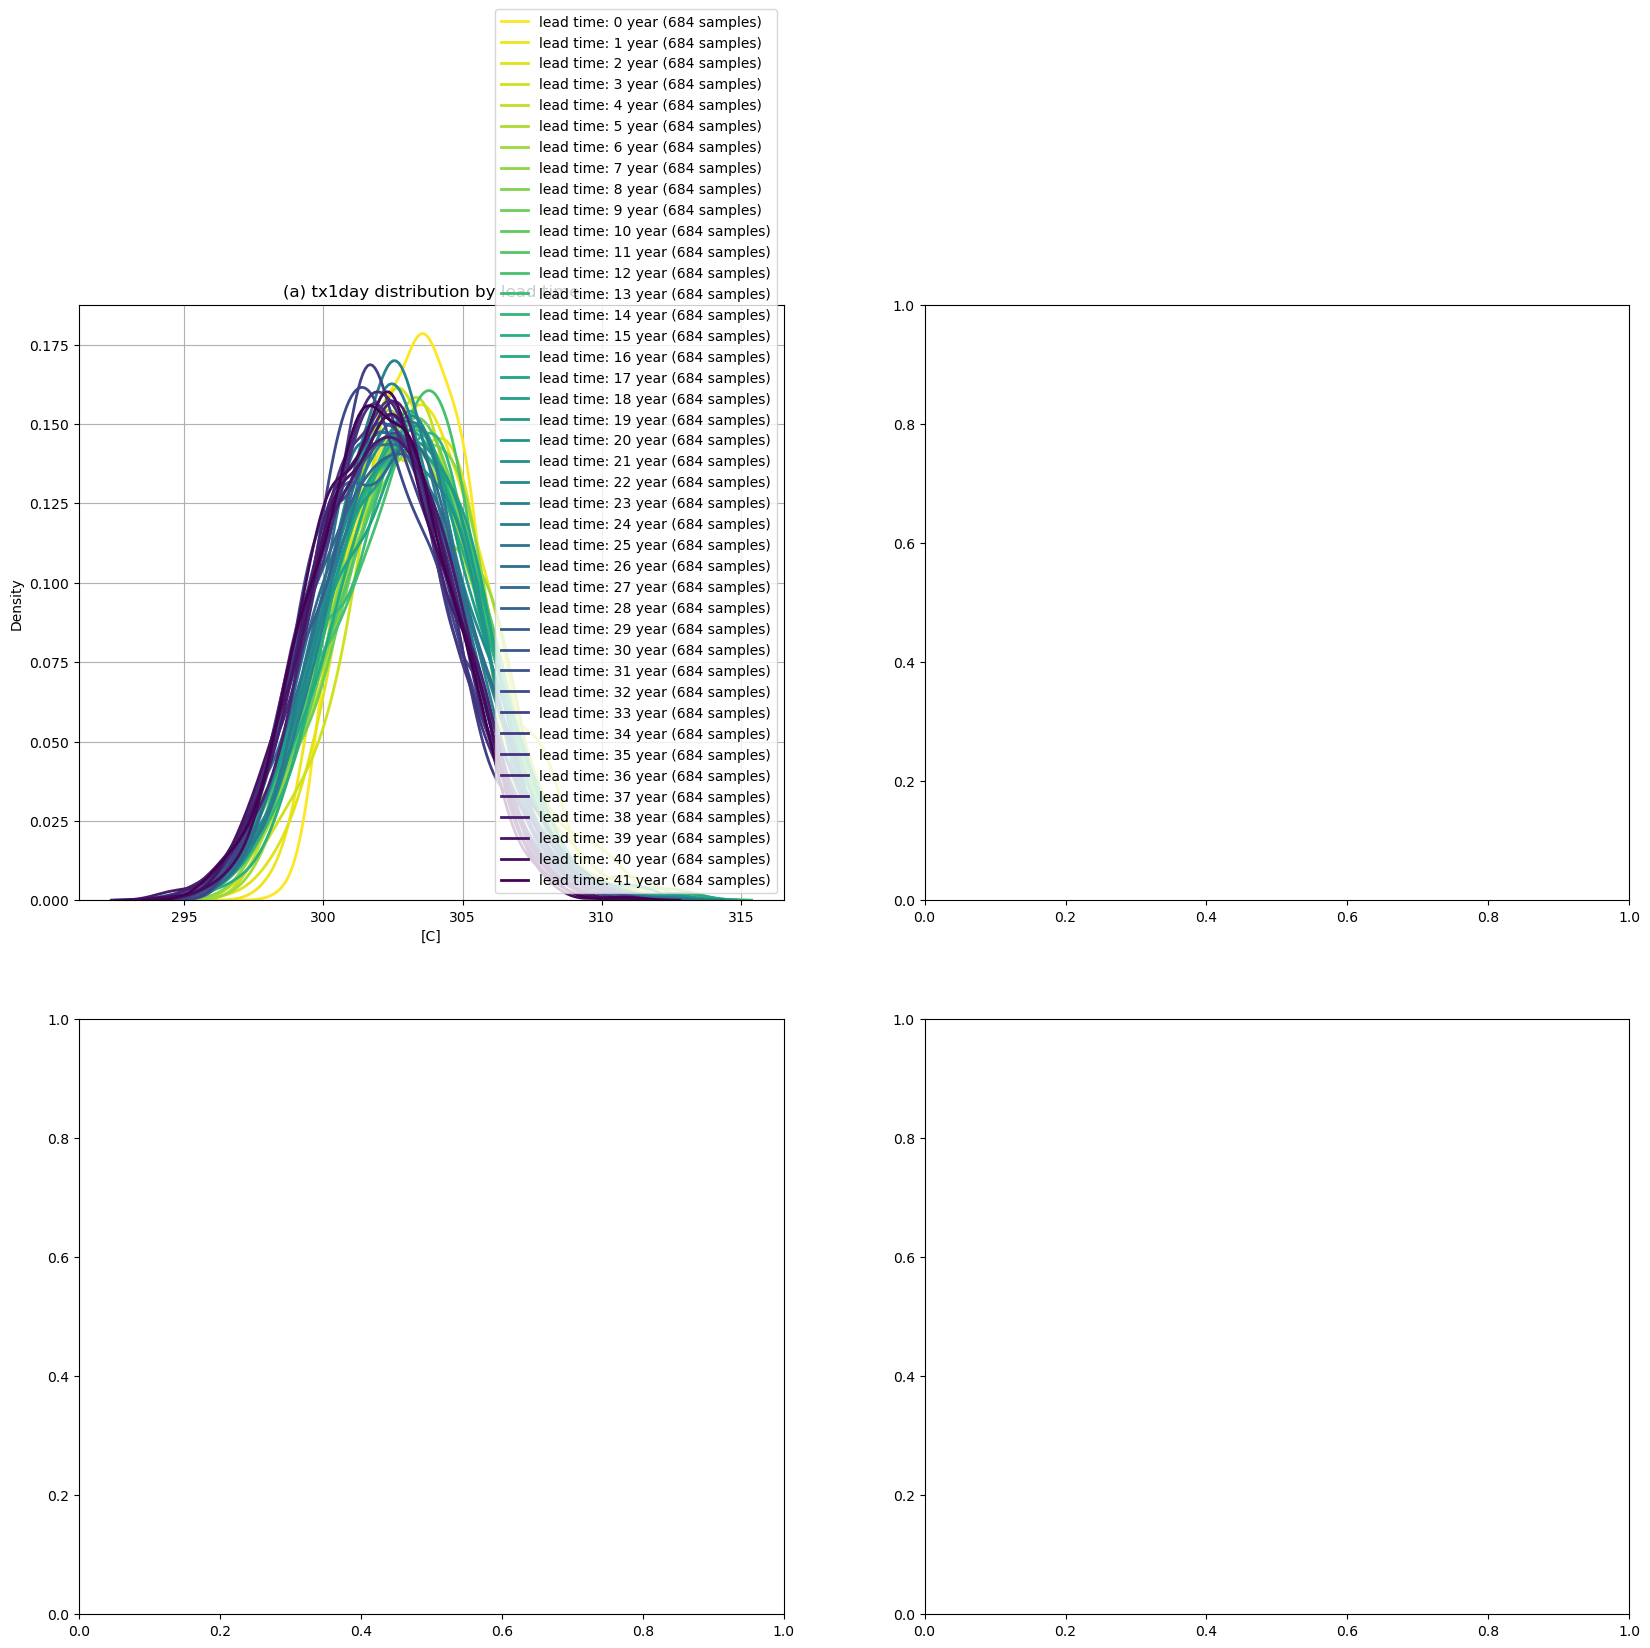

In [39]:
%%time

stability.create_plot(
    ds,
    'tx1day',
    np.arange(1981, 2018 + 1),
    uncertainty=True,
    return_method='gev',
    units='[C]',
    #ylim=(0, 450),
    outfile=str(home / f"{index}_stability_{model}.png"),
)